# Prototype Transformer Autoencoder Implementation

Here we will use proper `keras.Layer` and `tf.Model` abstractions to implement a realistic MVP for the transformer autoencoder. 

## Framing 
...

## Diverging: System setup
 - **Layer**: Transformer block. 
	 - Sublayer 1: MHA + layernorm. 
	 - Sublayer 2: FFN + layernorm. 
	 - NOTE: Must call `MHA._build_from_signature()` function in `build()` of the transformer block layer. 
	 - Input: Keys, values. 
 - Encoder: Progressively compressing the `M x D` input to `N x C` with transformer blocks. 
	 - Query: __learnable__ positional encoding for the `N x C` dimension. 
	 - Several __distinct__ transformer blocks with `query` = positional encoding, `key-value` = input byte array. 
	 - Finally: cross attention between {input, current latent embedding} -> {new latent}. 
 - Latent->latent: Self attention transformer block. 
	 - Adjustable number of distinct blocks -> `superblock`. 
	 - Adjustable number of `superblock_repeats`. 
	 - Adjustable frequency of inserting the `encoder` signal again. 
 - Decoder: Query = `M x D` positional encoding; key-values = `latent`. 
	 - Adjustable number of re-querying cycles. 
	 - Adjustable number of re-exposures to the latent values(?)
	 - Option for using a _learned_ query rather than constant positional encoding... 
	 	 - Only really makes sense for _full_ autoencoding -- not for partial recover in Vision NCA-style.

## Converging: MVP System 
 - **Transformer Layer**: Still required. 
 - **Encoder**: One transformer block with `query` = latent/learned initial latent, `key-value` = input byte array.
 - **Decoder**: One transformer block with `query` = positional encoding for original array, `key-value` = latent array. 
 - **Latent evolver**: # unique blocks and # repeats are still adjustable...
 - We will leave adjustable re-querying/etc. to the next iteration. We just need this one to function. 

> BIG GOAL: Overfit to a couple of training examples. Show that it can reconstruct an image or something. 
 - __Next__: Once we have the patch->video thing running, we can try it on a properly patched/encoded video. For now, we will just use a single frame with each row as a token. 

## 0: Data Acquisition & Imports

In [1]:
## Import Box 
import os 
import sys 
import random
import pathlib
import itertools
import collections
import math

import tensorflow as tf 
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
# Some modules to display an animation using imageio.
import imageio

2022-10-10 22:52:02.625781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-10 22:52:02.947866: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-10 22:52:03.099321: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-10 22:52:04.269032: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
## GPU Setup
physical_devices = tf.config.list_physical_devices("GPU")
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)


In [74]:
## Get some data 
# Utility imports  
sys.path.append("../src")
import video_loader as vl
import video_preprocess as vp 

## Meta/constants 
DATA_FOLDER = "../datasets/downloads"
num_videos, num_frames = 16, 20
output_size = (120, 180)

patch_height = 16
patch_width = 16
patch_duration = 3

batch_size=1

# Fourier feature codes 
k_space = 15
mu_space = 20 
k_time = 64 
mu_time = 200

print("Getting VideoSet...")
VideoSet = vl.get_videoset("../datasets/downloads", num_videos, num_frames, output_size=output_size)

print("Making patches from Videoset...")
PatchSet = vp.make_patchset(VideoSet, patch_duration, patch_height, patch_width)

print("Making the flat patch set...")
FlatPatchSet = vp.patch_to_flatpatch(PatchSet, batch_size=batch_size)

print("Adding codes to the PatchSet...")
CodedPatchedSet = PatchSet.map(lambda x: vp.add_spacetime_codes(x, 
		k_space=k_space, mu_space=mu_space, k_time=k_time, mu_time=mu_time))

print("Flattening the coded + patched dataset...")
FlatCodedPatchedSet = vp.patch_to_flatpatch(CodedPatchedSet, batch_size=batch_size)

Getting VideoSet...


100%|██████████| 16/16 [00:01<00:00,  8.48it/s]


Making patches from Videoset...
Making the flat patch set...
Flattening a tensor of shape:  (None, 6, 7, 11, 2304)
Adding codes to the PatchSet...
Flattening the coded + patched dataset...
Flattening a tensor of shape:  (1, 6, 7, 11, 2495)


In [96]:
## Obtaining a single greyscale frame from a video

video_num = 2

frame_list = []

# Getting a candidate frame 
cnt = 0
for element in VideoSet: 
	cnt += 1
	candidate_frame = element
	reconstruct_me = candidate_frame[:, -1, :,:,0]

	## Now with basic positional encoding
	video_height = reconstruct_me.shape[-2]
	pos_code = tf.range(0, 1, 1/video_height) 
	pos_code = tf.expand_dims(pos_code, axis=0)
	pos_code = tf.expand_dims(pos_code, axis=-1)

	poscode_reconstruct_me = tf.concat([reconstruct_me, pos_code], axis=2)
	poscode_reconstruct_me.shape
	frame_list.append(poscode_reconstruct_me)

Shape of poscode reconstruction tensor:  (16, 120, 181)


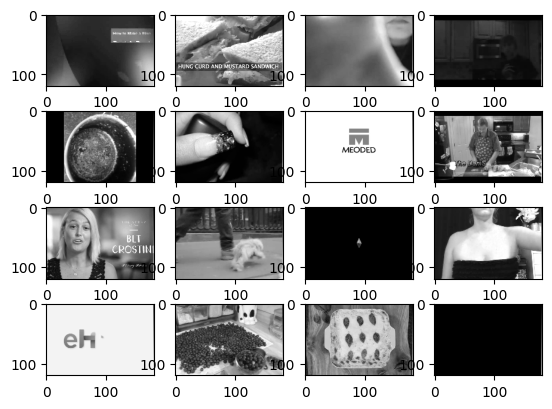

In [97]:
poscode_reconstruct_me = tf.concat(frame_list, axis=0)
print("Shape of poscode reconstruction tensor: ", poscode_reconstruct_me.shape)

fig, axs = plt.subplots(4,4)

for i in range(4): 
	for j in range(4): 
		axs[i,j].imshow(poscode_reconstruct_me[i+j*4,:,:], cmap='gray')
		# print(ty?pe(axs[0,0]))

## 1: Transformer Layers 

In [98]:
class TFLayer(keras.layers.Layer):
	def __init__(self, input_dim, output_dim=None, n_heads=15, key_dim=15, mha_dropout=0.0): 
		""" Transformer block. 

		args: 
			`input_dim`: 	Input dim for the pointwise MLP. The hidden layer will be 4x this. 
		kwargs: 
			`output_dim`: 	Dimensionality of the output tokens. If unspecified, defaults to `input_dim`. 
			`n_heads`:		Number of heads in the MHA layer. 
			`key_dim`:		Dimensionality of keys within the MHA layer. 
			`mha_dropout`: 	Dropout rate for the multihead attention layer. 
		"""
		super(TFLayer, self).__init__() 

		if output_dim == None: 
			output_dim = input_dim

		value_dim = input_dim # values outputted by the MHA layer 

		self.MHA = keras.layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, value_dim=value_dim, dropout=mha_dropout)
		self.conv1 = keras.layers.Conv1D(input_dim*4, 1, activation="relu")
		self.conv2 = keras.layers.Conv1D(output_dim, 1, activation="linear") 

		# TODO: Double check that this is normalizing along the right axes.
		self.layer_norm = tf.keras.layers.LayerNormalization()

	# def build(self, input_shape): 
	# 	# self.MHA._build_from_signature(input_shape)
	# 	... # TODO: How does this `build_from_signature` thing work? 

	def call(self, queries, keys, verbose=False): 
		""" Invokes the transformer block on the given queries and keys. 
		"""
		mha_out = self.MHA(queries, keys)

		if verbose:
			print("mha_out_shape_1: ", mha_out.shape)

		if queries.shape == keys.shape:
			mha_out = self.layer_norm(mha_out + queries)
			if verbose: 
				print(" ** Residual connection successful on MHA.")

		ffn_out = self.conv1(mha_out) 
		if verbose: 
			print("ffn_out_1 shape: ", ffn_out.shape)
		
		ffn_out = self.conv2(ffn_out) 
		if verbose: 
			print("ffn_out_2 shape: ", ffn_out.shape)

		if ffn_out.shape == mha_out.shape:
			if verbose: 
				print(" ** Residual connection successful on FFN")
			return self.layer_norm(ffn_out + mha_out)
			
		return self.layer_norm(ffn_out)

### Test 1: Self Attention on Image 

In [99]:
poscode_reconstruct_me.shape
# Lets add a couple of these in "batches" to make sure it'll work. 
# poscode_reconstruct_me = tf.concat([poscode_reconstruct_me for i in range(4)], axis=0)
poscode_reconstruct_me.shape

TensorShape([16, 120, 181])

In [100]:
input_dim = poscode_reconstruct_me.shape[-1]
test_block = TFLayer(input_dim)

TensorShape([16, 120, 181])

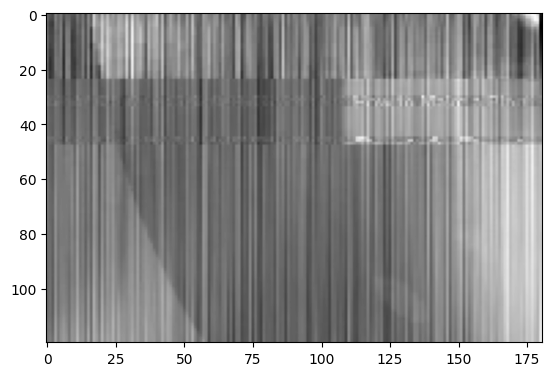

In [101]:
block_out = test_block(poscode_reconstruct_me, poscode_reconstruct_me)
plt.imshow(block_out[0,:,:], cmap='gray')

block_out.shape

In [102]:
block_out[1,:,:] == block_out[0,:,:]

<tf.Tensor: shape=(120, 181), dtype=bool, numpy=
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])>

### Test 2: Projecting Down to Latent Dim

In [103]:
## Single set of positional codes: 
N, C = 32, 48
B, M, D = poscode_reconstruct_me.shape

num_idx = N
k = C
mu = 30

codes = vp.get_fourier_codes(num_idx, k, mu)
codes = tf.expand_dims(codes, axis=0)

codes = tf.concat([codes for i in range(B)], axis=0)

print("Codes shape: ", codes.shape)

print("N, C = ", (N, C))
print("B, M, D = ", (B, M, D))

Codes shape:  (16, 32, 97)
N, C =  (32, 48)
B, M, D =  (16, 120, 181)


In [104]:
input_dim = 181
output_dim = C # 48 -- output of FFN layer
encoder_block = TFLayer(input_dim, output_dim=C)

Encoder output shape:  (16, 32, 48)
Desired output shape N x C:  (32, 48)


Text(0.5, 1.0, 'Encoder Output (untrained)')

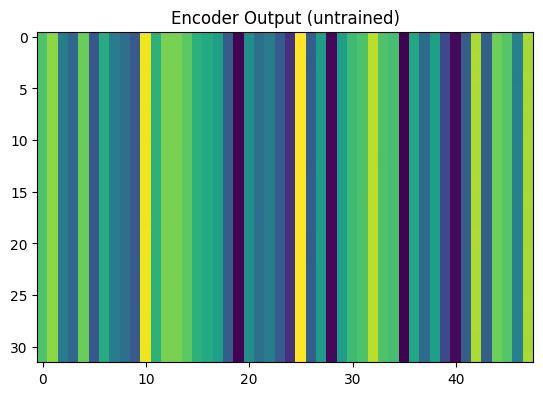

In [105]:
encoder_output = encoder_block(codes, poscode_reconstruct_me)
print("Encoder output shape: ", encoder_output.shape)
print("Desired output shape N x C: ", (N, C))
plt.imshow(encoder_output[0,:,:])
plt.title("Encoder Output (untrained)")

Text(0.5, 1.0, 'Positional Codes')

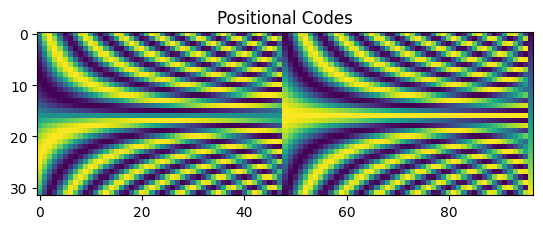

In [106]:
plt.imshow(codes[0,:,:])
plt.title("Positional Codes")

### Test 3: Projecting Up from Latent Dimension

In [107]:
input_dim = encoder_output.shape[-1] # dimensionality of each token

decoder_block = TFLayer(input_dim, output_dim=D)

k_out, mu_out = 15, M/2
positional_queries = vp.get_fourier_codes(M, k, M)
positional_queries = tf.expand_dims(positional_queries, axis=0)

positional_queries_ = tf.concat([positional_queries for i in range(B)], axis=0)
positional_queries = positional_queries_

positional_queries.shape

TensorShape([16, 120, 97])

Decoder output shape:  (16, 120, 181)


Text(0.5, 1.0, 'Decoder Output (untrained)')

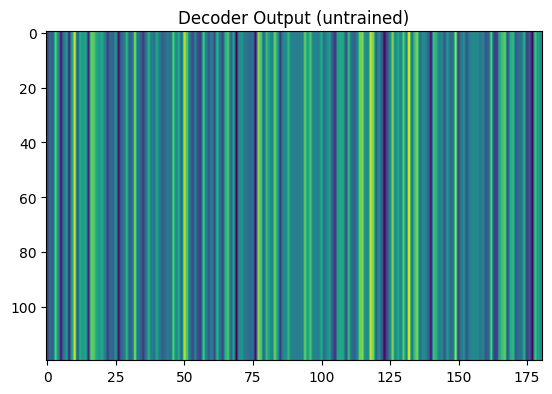

In [108]:
decoder_out = decoder_block(positional_queries, encoder_output) 
print("Decoder output shape: ", decoder_out.shape)
plt.imshow(decoder_out[0,:,:])
plt.title("Decoder Output (untrained)")

In [109]:
poscode_reconstruct_me.shape

TensorShape([16, 120, 181])

## 2: Perceiver Model

In [110]:
class MVP_TAE(keras.Model): 
	def __init__(self, n_latent_blocks=3, n_latent_repeats=3, D=181, N=90, C=77, k_in=None, mu_in=None, k_out=None, mu_out=None):
		super(MVP_TAE, self).__init__()
		self.n_latent_blocks = n_latent_blocks  	# number of blocks per latent superblock
		self.n_latent_repeats = n_latent_repeats 	# number of latent superblock repeats 


		## Getting positional codes for input (i.e., starting latent state)
		if C % 2 == 0: 
			C += 1
			print("Channel dimension must be odd for latent space -- adding 1.")

		self.N = N
		self.C = C

		self.k_out = k_out 
		self.mu_out = mu_out

		if k_in == None: 
			k_in = int(C/2) 
		if mu_in == None: 
			mu_in = N 

		self.k_in = k_in
		self.mu_in = mu_in

		self.reset_latent()
		

		

		## Creating the encoder block.
		self.encoder_block = TFLayer(input_dim, output_dim=C)

		## Creating the latent -> latent block 
		self.latent_block = TFLayer(self.C)

		## Creating the decoder block. 
		self.decoder_block = TFLayer(input_dim, output_dim=D)

	def reset_latent(self, B = 1):
		self.latent = vp.get_fourier_codes(self.N, self.k_in, self.mu_in)
		# self.latent = tf.Variable(tf.expand_dims(self.latent, axis=0))
		self.latent = tf.expand_dims(self.latent, axis=0)
		latent_ = tf.concat([self.latent for i in range(B)], axis=0) 
		self.latent = latent_
		print("Latent start shape = ", self.latent.shape)
		print("\tDesired N, C: ", (self.N, self.C))

	def call(self, reconstruct_me, verbose=0):
		""" Verbose = 0 -> no output. 
			Verbose = 1 -> output from messages within this level. 
			Verbose = 2 -> subcalls to layers are verbose too.
		"""
		## Getting positional codes for decoder 
		self.reset_latent()

		M = reconstruct_me.shape[1]
		B = reconstruct_me.shape[0] # batch size 
		if self.k_out == None: 
			self.k_out = int(D/2)

		self.mu_out = M

		self.output_query = vp.get_fourier_codes(M, self.k_out, mu_out)
		self.output_query = self.output_query[:M, :]
		self.output_query = tf.expand_dims(self.output_query, axis=0)
		self.output_query_ = tf.concat([self.output_query for i in range(B)], axis=0)
		self.output_query = self.output_query_

		self.reset_latent(B=B)

		if verbose >= 1:
			print("Output query size: ", self.output_query.shape)
			print("Input size: ", reconstruct_me.shape)

		## Encoding the input, compressing to latent dimension
		for i in range(self.n_latent_repeats):

			if verbose >= 1:
				print("Encoding the input with latent: ", self.latent.shape)		
			encoder_out = self.encoder_block(self.latent, reconstruct_me, verbose=verbose==2)
			if verbose >= 1:
				print("Encoder output: ", encoder_out.shape)

			self.latent = encoder_out

			for j in range(self.n_latent_blocks): 
				self.latent = self.latent_block(self.latent, self.latent, verbose=verbose==2)

		## Decoding the input
		if verbose >= 1: 
			print("\nDECODING: ")
		decoded = self.decoder_block(self.output_query, self.latent, verbose=verbose==2)

		return decoded

In [111]:
mvp_tae = MVP_TAE(n_latent_blocks=1, n_latent_repeats=1)

Latent start shape =  (1, 90, 77)
	Desired N, C:  (90, 77)


In [112]:
decoded = mvp_tae(poscode_reconstruct_me, verbose=2)

Latent start shape =  (1, 90, 77)
	Desired N, C:  (90, 77)
Latent start shape =  (16, 90, 77)
	Desired N, C:  (90, 77)
Output query size:  (16, 120, 181)
Input size:  (16, 120, 181)
Encoding the input with latent:  (16, 90, 77)
mha_out_shape_1:  (16, 90, 77)
ffn_out_1 shape:  (16, 90, 192)
ffn_out_2 shape:  (16, 90, 77)
 ** Residual connection successful on FFN
Encoder output:  (16, 90, 77)
mha_out_shape_1:  (16, 90, 77)
 ** Residual connection successful on MHA.
ffn_out_1 shape:  (16, 90, 308)
ffn_out_2 shape:  (16, 90, 77)
 ** Residual connection successful on FFN

DECODING: 
mha_out_shape_1:  (16, 120, 181)
ffn_out_1 shape:  (16, 120, 192)
ffn_out_2 shape:  (16, 120, 181)
 ** Residual connection successful on FFN


Text(0.5, 1.0, 'Untrained Outputs')

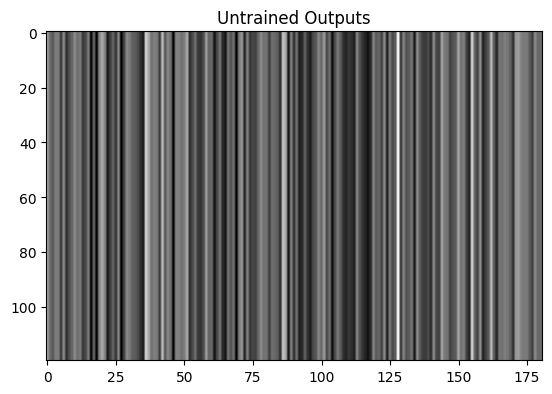

In [113]:
plt.imshow(decoded[0,:,:], cmap='gray')
plt.title("Untrained Outputs")

In [114]:
mvp_tae.summary()

Model: "mvp_tae_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_layer_26 (TFLayer)       multiple                  275048    
                                                                 
 tf_layer_27 (TFLayer)       multiple                  262173    
                                                                 
 tf_layer_28 (TFLayer)       multiple                  315400    
                                                                 
Total params: 852,621
Trainable params: 852,621
Non-trainable params: 0
_________________________________________________________________


In [115]:
## Training loop! 
# Compiling the model 
mvp_tae.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
)

In [116]:
history = mvp_tae.fit(poscode_reconstruct_me, poscode_reconstruct_me, batch_size=1, epochs=3200, validation_split=0.0, verbose=1)

Epoch 1/3200
Latent start shape =  (1, 90, 77)
	Desired N, C:  (90, 77)
Latent start shape =  (1, 90, 77)
	Desired N, C:  (90, 77)
Latent start shape =  (1, 90, 77)
	Desired N, C:  (90, 77)
Latent start shape =  (1, 90, 77)
	Desired N, C:  (90, 77)
16/16 [==============================] - 1s 10ms/step - loss: 1.0705
Epoch 2/3200
16/16 [==============================] - 0s 12ms/step - loss: 0.7256
Epoch 3/3200
16/16 [==============================] - 0s 12ms/step - loss: 0.5361
Epoch 4/3200
16/16 [==============================] - 0s 11ms/step - loss: 0.4174
Epoch 5/3200
16/16 [==============================] - 0s 11ms/step - loss: 0.3794
Epoch 6/3200
16/16 [==============================] - 0s 12ms/step - loss: 0.3490
Epoch 7/3200
16/16 [==============================] - 0s 11ms/step - loss: 0.3207
Epoch 8/3200
16/16 [==============================] - 0s 11ms/step - loss: 0.3047
Epoch 9/3200
16/16 [==============================] - 0s 12ms/step - loss: 0.3008
Epoch 10/3200
16/16 [=====

Text(0.5, 1.0, 'Model loss per iteration')

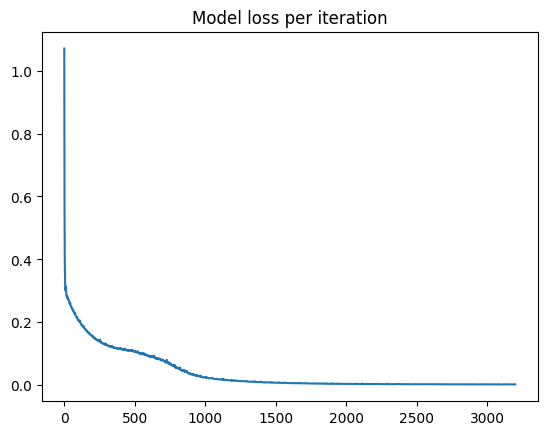

In [117]:
plt.plot(history.history['loss'])
plt.title("Model loss per iteration")

Latent start shape =  (1, 90, 77)
	Desired N, C:  (90, 77)
Latent start shape =  (16, 90, 77)
	Desired N, C:  (90, 77)


Text(0.5, 0.98, 'Reconstructions (Overfit)')

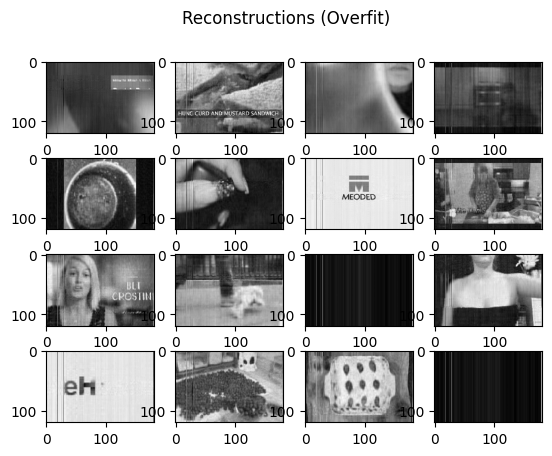

In [122]:
decoded = mvp_tae(poscode_reconstruct_me)

fig, axs = plt.subplots(4,4)

for i in range(4): 
	for j in range(4): 
		axs[i,j].imshow(decoded[i+j*4,:,:], cmap='gray')
		# print(ty?pe(axs[0,0]))

fig.suptitle("Reconstructions (Overfit)")

Text(0.5, 0.98, 'Source Images (Overfit)')

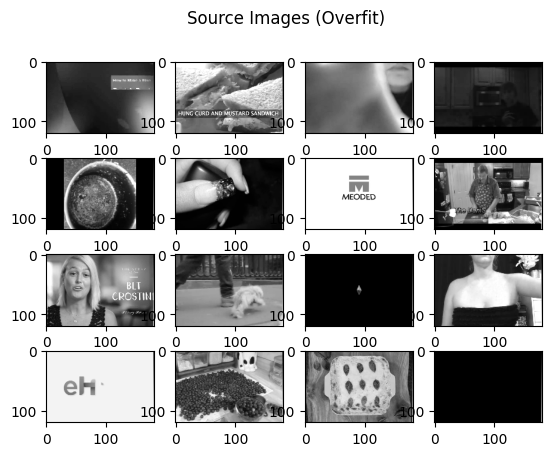

: 

In [123]:
fig, axs = plt.subplots(4,4)

for i in range(4): 
	for j in range(4): 
		axs[i,j].imshow(poscode_reconstruct_me[i+j*4,:,:], cmap='gray')
		# print(ty?pe(axs[0,0]))

fig.suptitle("Source Images (Overfit)")